In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from gnn_call_stack.utils import wandb_mean_std
_rng = np.random.default_rng(12345)

In [35]:


wandb_mean_std(["e8y7e0ou", "9bumfln1", "o0zx6mp2"]) # original_dfs
wandb_mean_std(["c7avzowa", "u8mhb0iq", "poa70hk4"]) # no_collection
wandb_mean_std(["bnlzqfib", "e0pz310w", "eqq3rcx2"]) # no_stack-recurrent
wandb_mean_std(["vuf7fs0g", "9s497dm3", "krnfy24o"]) # attention
wandb_mean_std(["zhxi36tb", "426vuymc", "6wbn9vzy"]) # ours
wandb_mean_std(["owbk6m08", "oejiv4ne", "sdb8yuay"]) # nodelevel
wandb_mean_std(["jc3gb3qp", "jb21bgeu", "9vfie7q0"]) # no_tf
wandb_mean_std(["ed2ijksj", "hm7mtaoq", "ss7v2hcz"]) # no_valuenet
wandb_mean_std(["hmkvvvj5", "08tu68aa", "delfvqw2"]) # no_stack-no_stackhint
wandb_mean_std(["fvonygud", "j2pbhi22", "ci5c78lq"]) # recurrent


['orignal_dfs', 'orignal_dfs', 'orignal_dfs']
orignal_dfs & 99.79\%\pm0.20 & 53.92\%\pm14.06
['no_collection', 'no_collection', 'no_collection']
no_collection & 50.54\%\pm3.90 & 25.08\%\pm0.97
['no_stack-recurrent', 'no_stack-recurrent', 'no_stack-recurrent']
no_stack-recurrent & 100.00\%\pm0.00 & 78.65\%\pm5.44
['attention', 'attention', 'attention']
attention & 92.27\%\pm5.04 & 49.40\%\pm2.28
['ours', 'ours', 'ours']
ours & 98.00\%\pm0.60 & 73.00\%\pm6.31
['nodelevel', 'nodelevel', 'nodelevel']
nodelevel & 100.00\%\pm0.00 & 100.00\%\pm0.00
['no_tf', 'no_tf', 'no_tf']
no_tf & 71.73\%\pm2.14 & 43.88\%\pm15.73
['no_valuenet', 'no_valuenet', 'no_valuenet']
no_valuenet & 97.54\%\pm0.83 & 67.42\%\pm3.67
['no_stack-no_stack_hints', 'no_stack-no_stack_hints', 'no_valuenet']
no_stack-no_stack_hints & 76.56\%\pm14.66 & 69.37\%\pm5.02
['recurrent', 'recurrent', 'recurrent']
recurrent & 100.00\%\pm0.00 & 82.19\%\pm1.07


In [4]:
wandb_mean_std(["hmkvvvj5", "08tu68aa", "delfvqw2"])

no stack-no stack hints & 65.33\%$\pm$4.69 & 72.88\%$\pm$7.47\\


In [3]:
def _random_tree(nb_nodes: int, p: float=0.5, directed=True):
  mat = np.zeros((nb_nodes, nb_nodes))
  highest_node = 0
  def _continue_random_tree(i: int):
    nonlocal highest_node
    if highest_node + 1 >= nb_nodes:
      return

    mat[i, highest_node + 1] = 1
    highest_node += 1
    visit_next = highest_node
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      print(i, highest_node + 1)
      highest_node += 1
      _continue_random_tree(highest_node)
    _continue_random_tree(visit_next)

  _continue_random_tree(0)

  if not directed: # This might disconnect the graph
    mat *= np.transpose(mat)

  return mat

In [4]:
import collections


def _random_tree(nb_nodes: int, p: float=0.5, directed=True):
  mat = np.zeros((nb_nodes, nb_nodes))
  highest_node = 0
  nodes_queue = collections.deque([0])
  while nodes_queue and highest_node + 1 < nb_nodes:
    i = nodes_queue.pop()
    mat[i, highest_node + 1] = 1
    highest_node += 1
    nodes_queue.appendleft(highest_node)
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      highest_node += 1
      nodes_queue.appendleft(highest_node)

  def _continue_random_tree(i: int):
    nonlocal highest_node
    if highest_node + 1 >= nb_nodes:
      return

    mat[i, highest_node + 1] = 1
    highest_node += 1
    visit_next = highest_node
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      print(i, highest_node + 1)
      highest_node += 1
      _continue_random_tree(highest_node)
    _continue_random_tree(visit_next)

  _continue_random_tree(0)

  if not directed: # This might disconnect the graph
    mat *= np.transpose(mat)

  return mat

In [17]:
def show_graph_with_labels(*adjs, file_name=None):
  for i, adj in enumerate(adjs):
    rows, cols = np.where(adj == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    plt.figure(i)
    nx.draw(gr, node_size=500, # labels=[str(i) for i in range(adjacency_matrix.shape[0])],
            with_labels=True, arrows=True, node_color="#000")
    if file_name is not None:
      plt.savefig(file_name)
  plt.show()

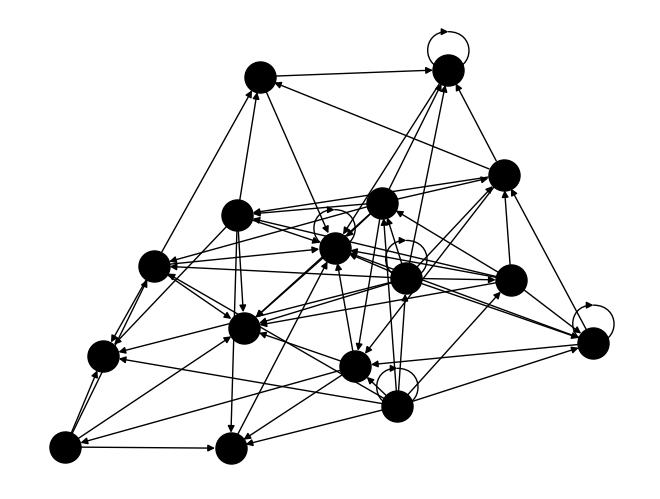

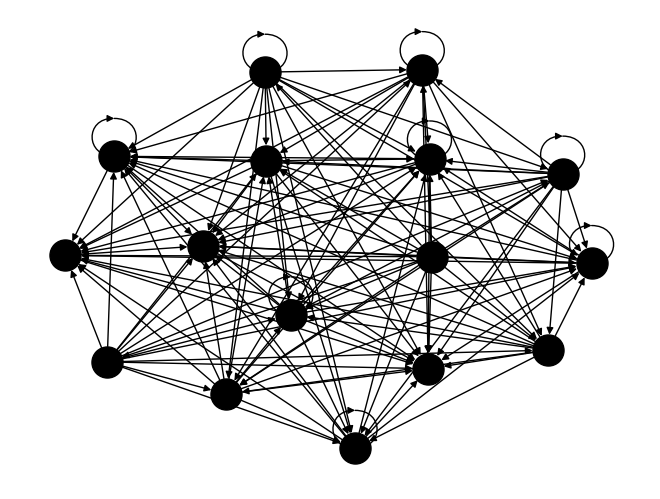

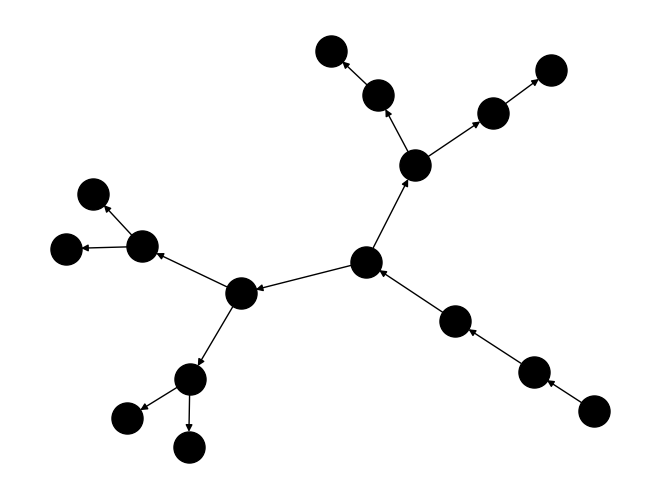

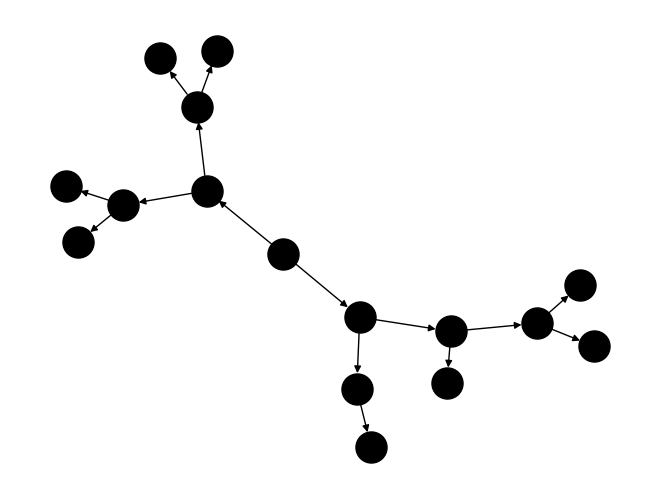

In [21]:
adj = _random_er_graph(nb_nodes=16, p=0.3, directed=True, acyclic=False, weighted=False)
show_graph_with_labels(adj, file_name="er1.pdf")
adj = _random_er_graph(nb_nodes=16, p=0.8, directed=True, acyclic=False, weighted=False)
show_graph_with_labels(adj, file_name="er2.pdf")

adj = _random_tree(16, 0.3)
show_graph_with_labels(adj, file_name="tree1.pdf")
adj = _random_tree(16, 0.8)
show_graph_with_labels(adj, file_name="tree2.pdf")


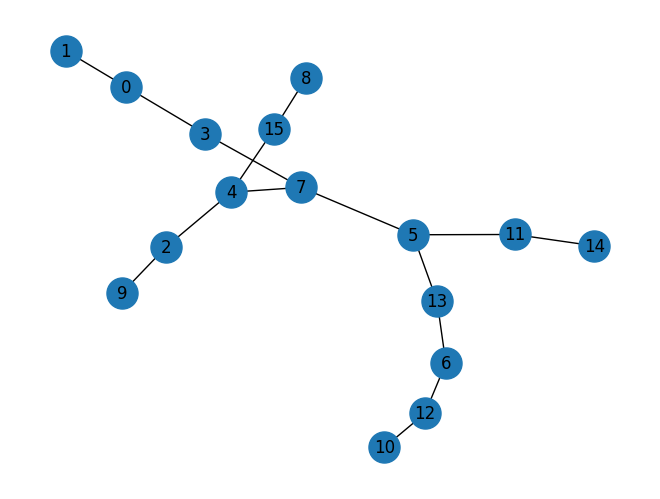

In [17]:
perm = _rng.permutation(adj.shape[0])
adj = adj[perm, :]
adj = adj[:, perm]
show_graph_with_labels(adj)

In [16]:
print(perm)

[13 15  2  8  7 12 14  9  0 11 10  4  6  1  3  5]


In [10]:
def _random_er_graph(nb_nodes, p=0.5, directed=False, acyclic=False,
                     weighted=False, low=0.0, high=1.0):
  """Random Erdos-Renyi  graph."""

  mat = _rng.binomial(1, p, size=(nb_nodes, nb_nodes))
  if not directed:
    mat *= np.transpose(mat)
  elif acyclic:
    mat = np.triu(mat, k=1)
    p = _rng.permutation(nb_nodes)  # To allow nontrivial solutions
    mat = mat[p, :][:, p]
  if weighted:
    weights = _rng.uniform(low=low, high=high, size=(nb_nodes, nb_nodes))
    if not directed:
      weights *= np.transpose(weights)
      weights = np.sqrt(weights + 1e-3)  # Add epsilon to protect underflow
    mat = mat.astype(float) * weights
  return mat

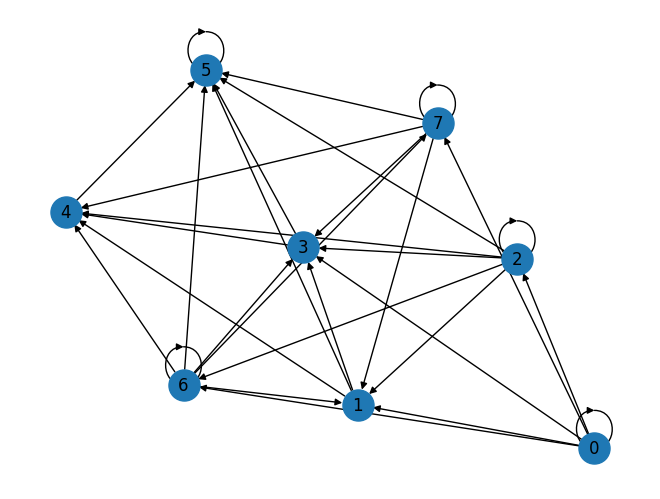

In [19]:

p=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lengths = [4, 8, 16, 24, 32]
adj = _random_er_graph(nb_nodes=_rng.choice(lengths), p=_rng.choice(p), directed=True, acyclic=False, weighted=False)
show_graph_with_labels(adj)

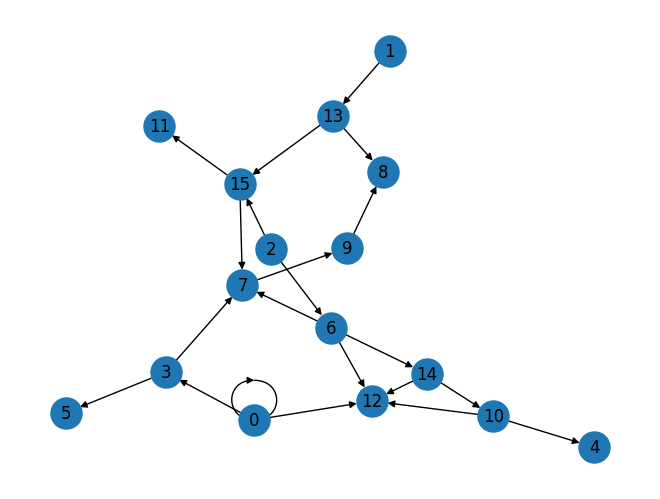

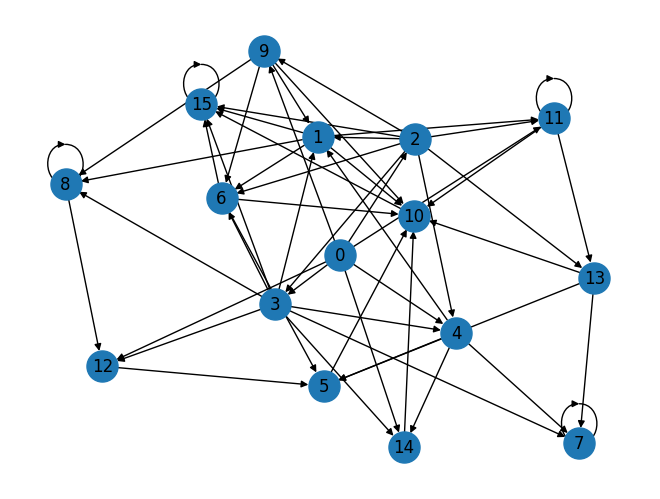

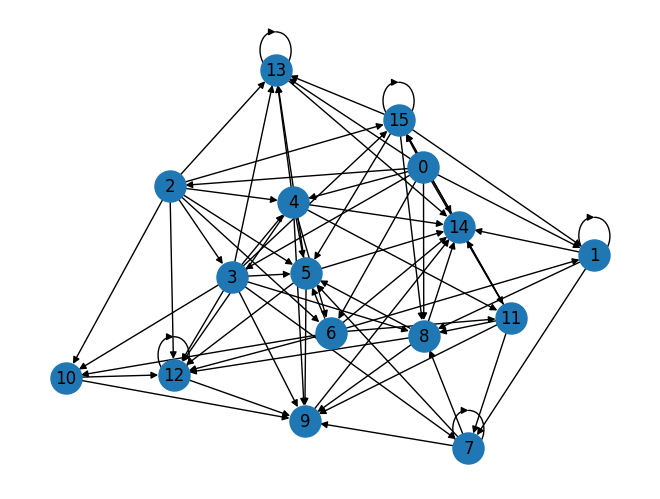

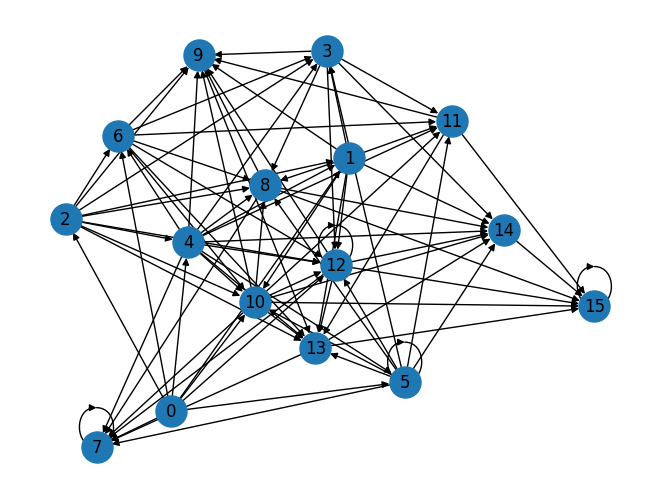

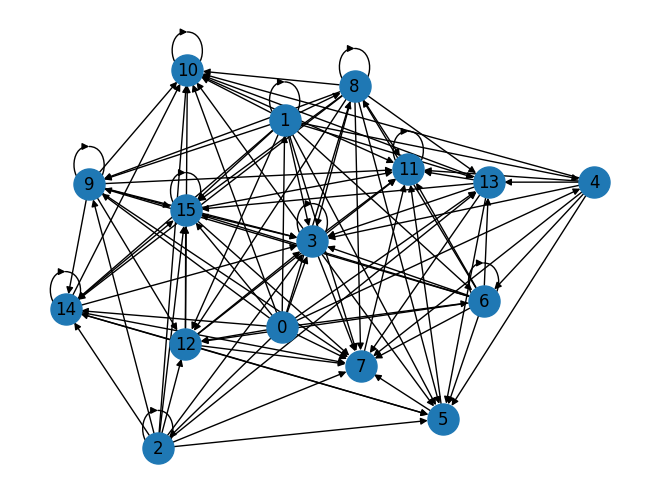

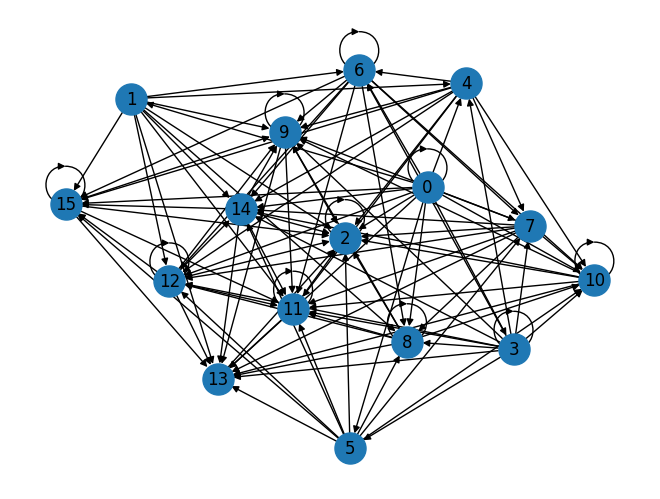

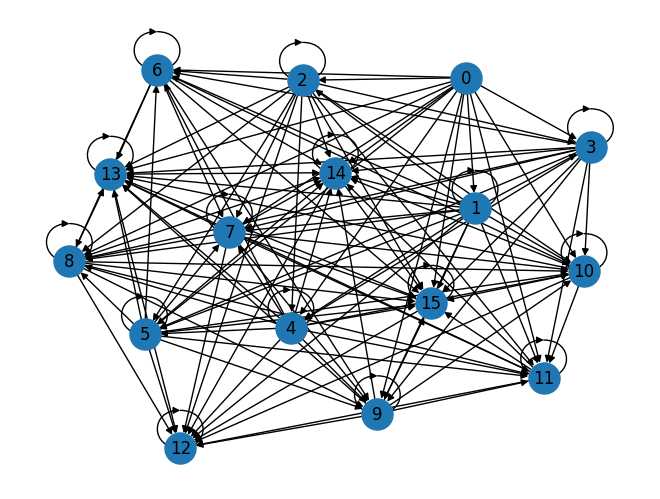

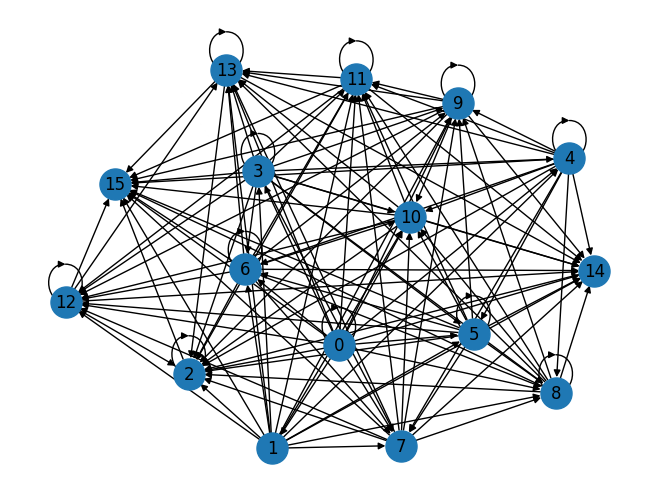

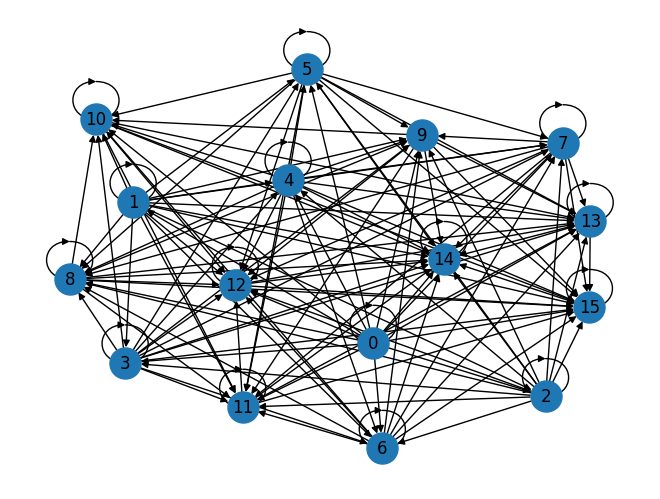

In [25]:
adjs = [_random_er_graph(nb_nodes=16, p=prob, directed=True, acyclic=False, weighted=False) for prob in p]
show_graph_with_labels(*adjs)